# HOST

**Author:** _Matteo Bagagli_ - **Date:** _10/2021_ - **Version:** _2.4.3_

-------------------------------------------------------------------------------------------------------------------

The **HOST** acronym stands for **H**igh-**O**rder-**ST**atistics seismic pickers.
This algorithm took inspiration from the one described in [_Baillard et al. 2014_](10.1785/0120120347). 
The idea behing this package is to provide user-friendly classes for seismic phase picking with _skewness_ and _kurtosis_ carachteristic-functions. I

Originally applied to seismograms by [_Saragiotis et al._](10.1109/TGRS.2002.800438), the HOS-CF are able to detect energic transient when the statistical properties of a seismogram (or time series) change abruptly. These CF are calculated on moving window with fixed window.

Measurements of statistical properties in a moving window are suitable for frequency-specific (or expected) transient. For this reason, the picker support a multi-window analysis, in order to collecto more information or even increase the quality of about 

**Both _skewness_ and _kurtosis_ are calculated with C-routine under the hood, making this package fast and suitable also for realtime picking porpouses.**

For the installation please refer to the `README.md` file in the project-home (for both standard and developer installation)


# Transformations Pipelines
-------------------------------------------------------

An additional feature provided by this package is the possibility to trasform the HOS-CF to get a more precise phase pick depending on data's nature and main feature. These **pipelines** are set with a dictionary that will be executed in order. 


Let's check them out!

First, let's import the `ObsPy` library and the package main class `Host`. 
This time we also need to import the `scaffold` module, that contains all the necessary transformation. Once loaded the waveform, we do a first standard pre-processing of the data.

In [1]:
# ----------------------------------------  To work
import sys
import logging
from obspy import read, UTCDateTime
from host.picker import Host
from host.plotting import plot_HOST
from host import scaffold as HSC

# ----------------------------------------  To show and log
%matplotlib inline 
logger = logging.getLogger()
logger.setLevel(logging.INFO)


def miniproc(st):
    prs = st.copy()
    prs.detrend('demean')
    prs.detrend('simple')
    prs.taper(max_percentage=0.05, type='cosine')
    prs.filter("bandpass",
               freqmin=1,
               freqmax=30,
               corners=2,
               zerophase=True)
    return prs

straw = read("../tests_data/obspy_read.mseed")
stproc = miniproc(straw)
trproc = stproc.select(channel="*Z")[0]
tr = trproc.copy()
# Trimming
tr.trim(UTCDateTime("2009-08-24T00:20:06.50000"),
        UTCDateTime("2009-08-24T00:20:08.30000"));

Now we want to initialize the main picker object, by providing the processed trace and the time-window (in seconds) for the CF calculation, and the `hos-method`. For the porpouse of demonstration, we will use the `kurtosis` of our signal. 
We will modify the transformation pipelines with the `set_transform_cf` class-method. Also this parameter (dictionary) can be specified, though, during the HOST object initialization.


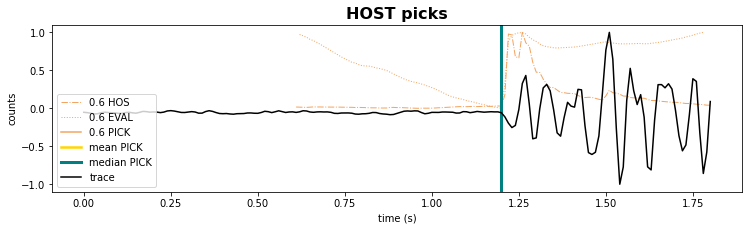

In [2]:
HP = Host(tr, 0.6, hos_method='kurtosis')  # also 'kurt' and 'k' works ... 
HP.work(debug_plot=True)

### Transformation - F2

Such a transformation is the one proposed in _Baillard et al. 2014_. It will create a _stair-like_ function of the time-series energy

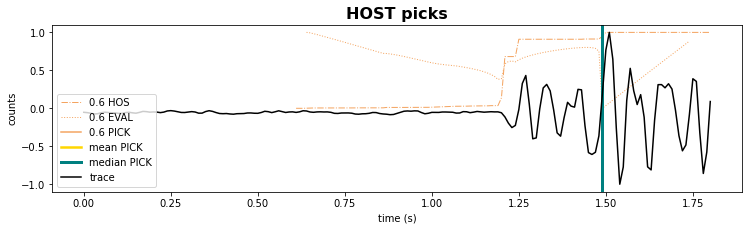

In [3]:
HP.set_transform_cf(
    {
        'transform_f2': {}  # this function is non-parametric
    }
)
HP.work(debug_plot=True)

... the `AIC` method though, is still unable to see the correct onset due to the higher-energy secondary arrival. Let's see how the `diff` method performs

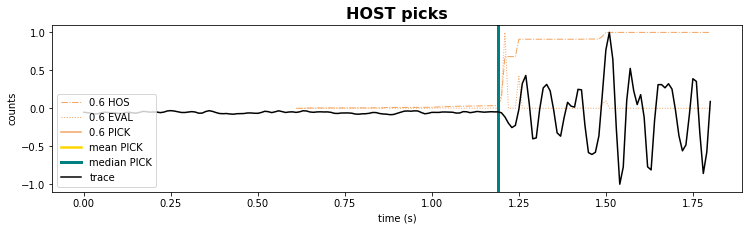

In [4]:
HP.set_detection_method('diff') # case insensitive, also 'gauss' works .. 
HP.set_diffgauss_threshold(2.5)
HP.work(debug_plot=True)

The `diff` method performs perfectly, as it clearly detect the correct sample. Let's see the other transformations ...

### Transformation - F3
Such a transformation is also similar to the one proposed in _Baillard et al. 2014_. It is just a _detrending-function_.

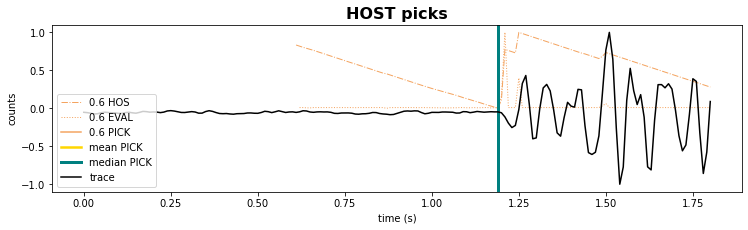

In [5]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {}   # this function is non-parametric      
    }
)
HP.work(debug_plot=True)

... as you see, the `diff` method still performs correctly and correctly detect the true arrival. Due to the HOST-CF shape, also the `min` detection would have work let's see!

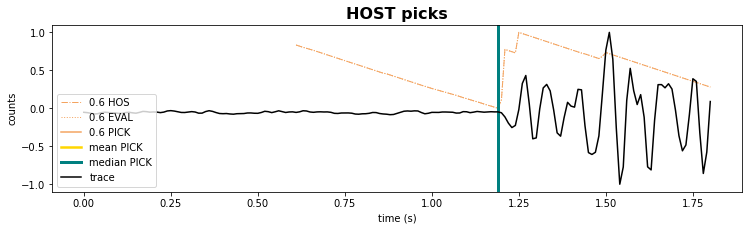

In [6]:
HP.set_detection_method('min')
HP.work(debug_plot=True)


### Transformation - F4

Such a transformation is also similar to the one proposed in _Baillard et al. 2014_. This function is _pushing down local minima_ and therefore our recently set `min` detection method will work flawlessy.


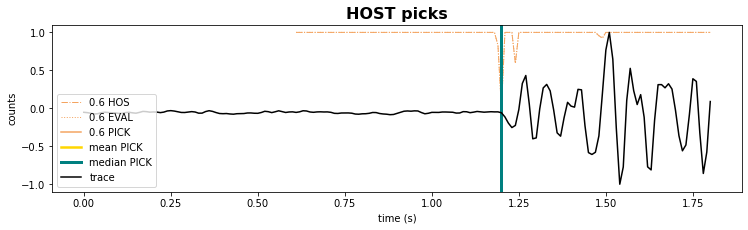

In [7]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_f4': {}   # this function is non-parametric         
    }
)
HP.work(debug_plot=True)

### Additional Transformation:

Additional transformations are:

- `transform_f5`: elevate the array to specified power (default 2.0). This step should help increase the S/N ratio.

- `transform_smooth`: smooth the CF with a window-length equal to the HOS-CF calculation and a `window_type` for the filtering (default `hanning`).

- `transform_smooth_custom`: smooth the CF with a custom window-length specified (seconds) and a `window_type` for the filtering (default `hanning`). 

For the possible parameter selection and their explanations, please refer to the documentation.


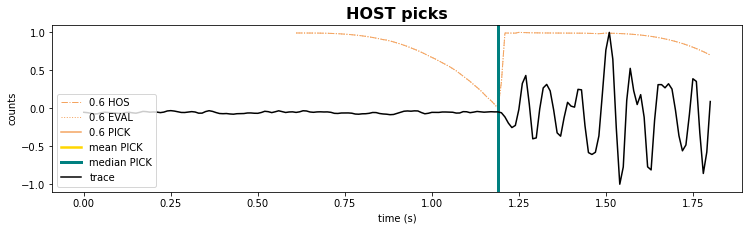

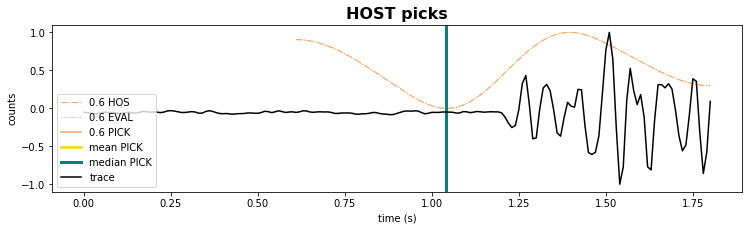

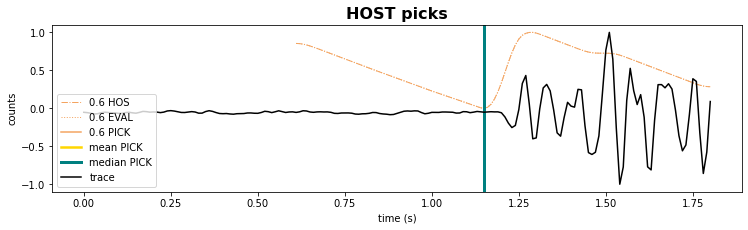

In [8]:
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_f5': {'power': 3.0}         
    }
)
HP.work(debug_plot=True)

# Or if we use the smooth STANDARD ... (same window-size used for CF calculation)
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_smooth': {'window_type': 'hanning'}  # 'flat', 'hanning', 'hamming',
                                                             # 'bartlett', 'blackman'
    }
)
HP.work(debug_plot=True)

# Or if we use the smooth CUSTOM ...
HP.set_transform_cf(
    {
        'transform_f2': {},  # this function is non-parametric
        'transform_f3': {},  # this function is non-parametric   
        'transform_smooth_custom': {'smooth_win': 0.15,
                                    'window_type': 'hanning'}  # 'flat', 'hanning',
                                                               # 'hamming', 'bartlett',
                                                               # 'blackman'
    }
)
HP.work(debug_plot=True)


Of course these `smoothing*` function are here to show the functionality, they are not really handy in this easy case scenario were one (or even none) CF transformations would be needed. These transformation though may come handy in case of more complex traces

Let's check indeed the 

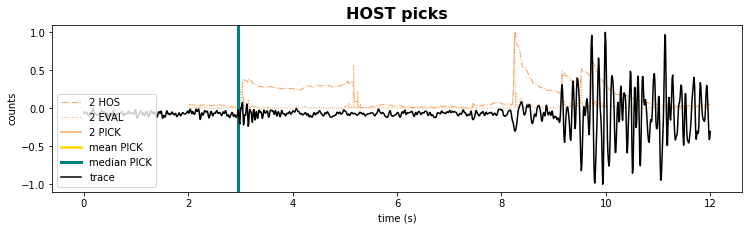

{'mean': 1970-01-01T00:00:02.960000Z,
 'median': 1970-01-01T00:00:02.960000Z,
 '2': 1970-01-01T00:00:02.960000Z,
 'pick_error': 2.6899999999999999,
 'valid_obs': {'2': 1970-01-01T00:00:02.960000Z},
 'outlier_obs': {}}

In [21]:

newtr = read("../tests_data/real_case.SAC")[0]
HP = Host(newtr, 2,  hos_method='kurtosis')  # also 'kurt' and 'k' works ... 
# HP.set_transform_cf(
#     {
#         'transform_f2': {},  # this function is non-parametric
#         'transform_f3': {},  # this function is non-parametric   
# #         'transform_smooth_custom': {'smooth_win': 2,
# #                                     'window_type': 'hanning'}  # 'flat', 'hanning',
# #                                                                # 'hamming', 'bartlett',
# #                                                                # 'blackman'
#     }
# )

HP.set_detection_method('diff')
HP.set_diffgauss_threshold(2)

HP.work(debug_plot=True)
HP.get_picks_UTC()


### References
- Baillard, C., Crawford, W.C., Ballu, V., Hibert, C. and Mangeney, A., 2014. An automatic kurtosis‐based P‐and S‐phase picker designed for local seismic networks. Bulletin of the Seismological Society of America, 104(1), pp.394-409.
- Saragiotis, C.D., Hadjileontiadis, L.J. & Panas, S.M., 2002. PAI-S/K: a robust automatic seismic P phase arrival identification scheme, IEEE Trans. Geosci. Remote Sens. 40, 1395–1404.